#### Summary:
In this notebook I'll run the DESeq RNA trait associations on Alberta and HPAP datasets separately before later combining these using Random Effects Model meta-analysis in the next notebook. All required inputs should have been made in the previous notebook 2a (except per cell type lists of expressed genes, TPM>1). This notebook runs DESeq on one dataset at a time, you'll need to adjust the dataset variable at the top and then rerun the code to run DESeq on both.

In [1]:
suppressMessages(library(dplyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(readr))
suppressMessages(library(meta))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

suppressMessages(library(DESeq2))
suppressMessages(library(fgsea))
suppressMessages(library(parallel))
suppressMessages(library(bettermc))
suppressMessages(library(qvalue))

# Basic Inputs

In [2]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

hpap_samples_rna <- c('HPAP-022','HPAP-026','HPAP-034','HPAP-035','HPAP-036',
                  'HPAP-037','HPAP-039','HPAP-040','HPAP-042','HPAP-044',
                  'HPAP-047','HPAP-052','HPAP-053','HPAP-054','HPAP-056',
                  'HPAP-059','HPAP-063','HPAP-074','HPAP-075','HPAP-077',
                  'HPAP-080','HPAP-082','HPAP-099','HPAP-101','HPAP-103',
                  'HPAP-104','HPAP-105')

In [3]:
outdir <- '/overall/dir/to/save/phenotype/association/outputs/to'

In [4]:
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal', 'endothelial', 'immune','stellate')

In [ ]:
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#F598C9','#FDBB84')
names(colors) <- joint_celltypes

In [5]:
#SET WHICH DATASET TO RUN DESEQ ON HERE!!!!
# dataset <- 'Alberta'
dataset <- 'HPAP'

# 1. Read in inputs previously generated (metadata df, gene TPM/cell type values)

## Donor metadata

In [6]:
meta_fp <- file.path(outdir, 'Alberta_HPAP_combined_metadata_all.tsv')
meta <- read.table(meta_fp, sep='\t')
dim(meta)
head(meta)
tail(meta)

[1] 62 56

,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,50,0.4825992,Female,22.2,-0.93547849,NA,NA,Alberta,70,0.07402343,⋯,1842.333,-0.7227589,1304.000,-0.69291246,1118.606,-0.869054467,1314.583,-0.9386930,3.450389,-1.2548308
R217,71,1.5811029,Female,35.5,1.15230857,6.3,1.6527657,Alberta,15,-1.34420328,⋯,1868.313,-0.6980603,1578.500,-0.11854077,1458.000,0.009333767,1771.000,-0.3702339,3.530508,-1.1219687
R218,73,1.6857223,Female,28.4,0.03777563,5.9,0.8536262,Alberta,70,0.07402343,⋯,1384.827,-1.1577107,1503.500,-0.27547292,910.250,-1.408302494,1505.200,-0.7012832,3.641667,-0.9376335
R221,44,0.1687410,Male,30.5,0.36742622,5.3,-0.3450829,Alberta,136,1.77589549,⋯,1625.554,-0.9288509,1376.625,-0.54094982,1460.600,0.016062849,1243.706,-1.0269696,3.792649,-0.6872598
R223,54,0.6918380,Male,27.0,-0.18199143,5.8,0.6538414,Alberta,64,-0.08069221,⋯,1854.044,-0.7116253,1592.143,-0.08999406,1568.125,0.294349182,1826.053,-0.3016668,2.992320,-2.0144478
R226,30,-0.5635948,Female,32.3,0.64998386,4.9,-1.1442224,Alberta,16,-1.31841734,⋯,2238.235,-0.3463746,1328.000,-0.64269417,2198.750,1.926474909,1739.250,-0.4097780,3.864731,-0.5677271


,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HPAP-092,21,-1.0343821,Male,25.59,-0.403328254,5.6,0.2542716,HPAP,48,-0.4932673,⋯,NA,NA,NA,NA,NA,NA,NA,NA,4.745936,0.8935767
HPAP-099,28,-0.6682142,Female,24.70,-0.543037312,5.0,-0.9444375,HPAP,NA,NA,⋯,3359.227,0.7193535,1974.645,0.7103648,1335.750,-0.3070625,3244.049,1.4644225,5.502476,2.1481485
HPAP-101,55,0.7441477,Female,38.01,1.546319508,5.0,-0.9444375,HPAP,96,0.7444579,⋯,2145.525,-0.4345142,1192.085,-0.9270865,1007.828,-1.1557611,1543.082,-0.6541014,5.359599,1.9112167
HPAP-103,48,0.3779798,Female,36.44,1.299866450,6.0,1.0534111,HPAP,144,1.9821830,⋯,2772.062,0.1611346,1754.500,0.2497267,1233.333,-0.5721279,1936.127,-0.1645711,5.255340,1.7383224
HPAP-104,4,-1.9236470,Male,20.63,-1.181931547,4.9,-1.1442224,HPAP,144,1.9821830,⋯,2889.504,0.2727869,1691.813,0.1185594,1325.455,-0.3337082,2231.083,0.2027913,4.768235,0.9305564
HPAP-105,51,0.5349089,Female,28.10,-0.009317313,5.2,-0.5448678,HPAP,48,-0.4932673,⋯,2729.804,0.1209606,1512.557,-0.2565211,1097.302,-0.9241927,1979.730,-0.1102645,4.832792,1.0376113


In [7]:
#subset down to samples in dataset and remove any with NA culture time 
if(dataset=='Alberta') fin_samples <- alberta_samples
if(dataset=='HPAP') fin_samples <- hpap_samples_rna
meta_fin <- meta[fin_samples,] %>% subset(!is.na(culture_time))
dim(meta_fin)

[1] 25 56

In [8]:
# IF we're doing HPAP only, add in additional HPAP metadata
if (dataset=='HPAP'){
    meta2 <- as.data.frame(fread('/path/to/full/HPAP/metadata.csv'))

    #Ruth's function: Diabetes_Status_w_AAB + tissue_source + chemistry + gender + scaled_culture_time + scaled_bmi + race + scaled_age_years
    meta2_cut <- select(meta2, race, donor_ID)
    row.names(meta2_cut) <- meta2_cut$donor_ID

    #manually set a few metadata vars, based on Ruth's code from github
    penn <- c('HPAP-022','HPAP-027','HPAP-034','HPAP-035','HPAP-037','HPAP-040','HPAP-047','HPAP-051','HPAP-052','HPAP-053','HPAP-054','HPAP-055','HPAP-056','HPAP-057','HPAP-059','HPAP-061','HPAP-063','HPAP-064','HPAP-074','HPAP-075','HPAP-077','HPAP-083','HPAP-085','HPAP-099','HPAP-103','HPAP-104','HPAP-106')
    v2 <- c('HPAP-019','HPAP-020','HPAP-021','HPAP-022','HPAP-023','HPAP-024','HPAP-026','HPAP-027','HPAP-028','HPAP-029','HPAP-032','HPAP-034','HPAP-035','HPAP-036','HPAP-037')

    meta2_cut$tissue_source <- ifelse(meta2_cut$donor_ID %in% penn, 'UPenn', 'nPOD')
    meta2_cut$chemistry <- ifelse(meta2_cut$donor_ID %in% v2, '10Xv2', '10Xv3')

    # merge back with meta_fin for correct samples
    meta_fin2 <- cbind(meta_fin, meta2_cut[row.names(meta_fin),-2])
    meta_fin <- meta_fin2    
}
head(meta_fin)

,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse,race,tissue_source,chemistry
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
HPAP-022,39,-0.09280753,Female,34.70,1.0267274,4.7,-1.5437921,HPAP,72,0.1255953,⋯,1.00907239,1812.945,0.92797036,3147.311,1.3439381,NA,NA,Caucasian,UPenn,10Xv2
HPAP-026,24,-0.87745303,Male,20.80,-1.1552455,4.9,-1.1442224,HPAP,48,-0.4932673,⋯,-0.93851128,1298.500,-0.40346949,1753.125,-0.3924969,NA,NA,Caucasian,nPOD,10Xv2
HPAP-034,13,-1.45285974,Male,18.60,-1.5005938,5.2,-0.5448678,HPAP,72,0.1255953,⋯,-0.41671186,1102.333,-0.91117005,2342.769,0.3418948,NA,NA,Caucasian,UPenn,10Xv2
HPAP-035,35,-0.30204633,Male,26.91,-0.1961193,5.2,-0.5448678,HPAP,72,0.1255953,⋯,-0.56223077,1295.737,-0.41062084,1923.038,-0.1808726,4.301869,0.1571798,Caucasian,UPenn,10Xv2
HPAP-036,23,-0.92976273,Female,16.00,-1.9087326,5.2,-0.5448678,HPAP,48,-0.4932673,⋯,0.71629646,1480.143,0.06664188,2347.103,0.3472930,4.297375,0.1497275,Caucasian,nPOD,10Xv2
HPAP-037,35,-0.30204633,Female,21.90,-0.9825714,5.3,-0.3450829,HPAP,96,0.7444579,⋯,-0.01765581,1346.077,-0.28033526,1856.314,-0.2639771,NA,NA,Caucasian,UPenn,10Xv2


## Cell type level TPM tables (for "expressed genes")

In [9]:
# Read in TPM matrices by cell type
tpm_dir <- '/dir/with/per/celltype/TPM/matrices'
tpm_tables <- list()
for (celltype in joint_celltypes){
    fp <- file.path(tpm_dir, sprintf('%s_genes_values.ALL_GENES.txt', celltype))
    df <- read.table(fp, sep='\t')
    colnames(df) <- c('gene', 'TPM')
    tpm_tables[[celltype]] <- df
}

In [10]:
head(tpm_tables[['beta']])

,gene,TPM
,<chr>,<dbl>
1,MALAT1,46915.751
2,INS,34436.004
3,PAM,3521.636
4,LINC01099,2897.259
5,RGS7,2688.381
6,AC096759.1,2250.007


# 2. Calculate Trait Associations with Genes

## Run DESeq for all variables (age, BMI, HbA1c, sex)
Function design: `~main variable + other metadata + scaled_culture_time + scaled_beta_prop_rna + scaled_ct_mean_genes`

In [11]:
mat_dir <- file.path(outdir, 'RNA','merged_sample_matrices')
files <- list.files(mat_dir)
files

#exclude cell types that we don't have many donors with lots of cells in (endothelial)
fin_files <- files

[1] "acinar_sample_RNA_total_counts.txt"     
[2] "alpha_sample_RNA_total_counts.txt"      
[3] "beta_sample_RNA_total_counts.txt"       
[4] "delta_sample_RNA_total_counts.txt"      
[5] "ductal_sample_RNA_total_counts.txt"     
[6] "endothelial_sample_RNA_total_counts.txt"
[7] "gamma_sample_RNA_total_counts.txt"      
[8] "immune_sample_RNA_total_counts.txt"     
[9] "stellate_sample_RNA_total_counts.txt"

In [12]:
### Function which runs the default DESeq analysis on each cell type total counts sample matrix
### focusing on one input variable (var), and including other_vars as covariates
### then sorts results by pvalue and writes to a file.
### Samples with NA values for the variable of interest (var) are removed, as well as samples with 
### no gex (eg some samples don't have schwann cells).
### Also filter out genes with pseudobulk TPM < set cutoff, option to include scaled_mean_genes covar, and 
### only use samples with a certain number of cells in the cell type, also don't use samples with min_cells_rna < 1000

run_deseq_one_main_variable_RNA <- function(files, var, other_vars, meta, out_prefix, log_fp, tpm_cutoff=0, min_cells_per_sample=20){
    write(sprintf('Starting DESeq run for %s: %s', var, Sys.time()), file=log_fp, append=TRUE)
    
    for (FILE in files) {
        # Read in cell type counts file (sample pseudobulk)
        cell <- gsub('_sample_RNA_total_counts.txt', '', FILE)
        print(FILE)
        raw_counts <- read.table(file.path(mat_dir, FILE), row.names=1)
        raw_counts <- raw_counts[,(colSums(raw_counts != 0) > 0)]
        colnames(raw_counts) <- gsub('\\.','-',colnames(raw_counts))
        meta_cell <- meta
        
        # Identify which samples we have gene expression and enough cells from and cut down matrices accordingly
        samples <- row.names(meta_cell)
        samples_meta <- row.names(meta_cell[!is.na(meta_cell[,var]),])
        cell_col <- paste0(cell,'_cells_rna')
        samples_w_cells <- row.names(meta %>% subset(meta[[cell_col]] >= min_cells_per_sample & num_cells_rna > 1000))
        samples_fin <- samples[samples %in% samples_meta & samples %in% samples_w_cells]
        meta_fin <- meta_cell[samples_fin,]
        raw_counts_fin <- raw_counts[,samples_fin]
        write(paste(cell, Sys.time(), length(samples_fin), 'samples to use'), file=log_fp, append=TRUE)
        write(paste(cell, Sys.time(), paste(samples_fin, collapse=',')), file=log_fp, append=TRUE)

        # If there are at least 10 samples with metadata, proceed with DESeq
        if (length(meta_fin[,var]) > 10){            
            # Light pre-filtering
            counts <- raw_counts_fin[rowSums(raw_counts_fin) >= 10,]
            write(paste(dim(counts)[1], 'genes pass light pre-filtering (>= 10 counts across samples)'), file=log_fp, append=TRUE)
            
            # Filter genes (raw_counts_fin) by >= TPM cutoff (default is 0)
            tpm_df <- tpm_tables[[cell]]
            pass_genes <- tpm_df[tpm_df$TPM >= tpm_cutoff,]$gene
            counts_fin <- counts[row.names(counts) %in% pass_genes,]
            write(paste(dim(counts_fin)[1], 'genes pass celltype pseudobulk TPM cutoff', tpm_cutoff), file=log_fp, append=TRUE)

            # Make function for DESeq using in the format: ~var + other_vars
            my_design <- as.formula(paste0(sprintf('~ %s',var),paste0(rep(' + ',length(other_vars)), c(other_vars, paste0('scaled_',cell,'_mean_genes')),collapse='')))
            write(as.character(my_design), file=log_fp, append=TRUE)
            print(my_design)
            
            # Run DESeq            
            dds  <- DESeqDataSetFromMatrix(round(counts_fin), colData = meta_fin, design = my_design) #colData is where design columns are found
            rld <- vst(dds)
            print(plotPCA(rld, intgroup = var)+ ggtitle(paste(cell,var)))
            dds <- DESeq(dds)
            
            # Extract results for variable of interest
            if (var == 'sex'){
                fin_var <- 'sex_Male_vs_Female'
            } else{
                fin_var <- var
            }
            res <- results(dds, name=fin_var)
            df <- as.data.frame(res)
            df <- df[order(df$pvalue),]
            fp <- paste0(out_prefix, cell, '.tsv')
            write.table(df, fp, sep="\t", quote=FALSE)
            write('\n', file=log_fp, append=TRUE)
        } else {
            write(paste(cell, Sys.time(), 'not enough samples to proceed!'), file=log_fp, append=TRUE)
        }
    }
    write(paste('Done', Sys.time()), file=log_fp, append=TRUE)
}

In [ ]:
# Use function to run deseq on all cell types for each variable of interest
variables <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
if(dataset == 'Alberta') add_variables <- c('scaled_culture_time', 'scaled_beta_prop_rna')
if(dataset == 'HPAP') add_variables <- c('scaled_beta_prop_rna', 'tissue_source', 'chemistry', 'race')

deseq_outdir <- file.path(outdir,'RNA',paste0(dataset,'_DESeq'))
dir.create(deseq_outdir, showWarnings=FALSE)

for (var in variables){
    print(paste(var, Sys.time()))
    
    # Make subdir in the outdir for the specific variable
    outdir_var <- file.path(deseq_outdir, var)
    dir.create(outdir_var, showWarnings = F)
    out_prefix <- file.path(outdir_var, sprintf('RNA_deseq_v4.%s.',var))
    log_fp <- file.path(deseq_outdir, sprintf('log_%s.txt', var))
    
    # Set other metadata variables to include in functions
    # removing HbA1c from other analyses for now since has NA values
    other_vars <- c(variables[variables != var & variables != 'scaled_HbA1c'] ,add_variables)
    print(other_vars)

    # Run DESeq
    run_deseq_one_main_variable_RNA(fin_files, var, other_vars, meta_fin, out_prefix, log_fp, tpm_cutoff=1, min_cells_per_sample=20)
    print('')
}

## 3b. Visualize summaries of DESeq results

In [15]:
### Function to make a barplot comparing the # of significant DEGs for a list of cell types and variables
summarize_DEGs <- function(deseq_outdir, variables, celltypes, plot_col, colors){
    # Organize list of all outputs (celltype and variable)
    prefixes <- paste(rep(variables, each = length(celltypes)), celltypes, sep='-')
    
    # Read in all deseq_output files, save summary info to a list
    data <- data.frame()
    for (prefix in prefixes){
        var <- str_split(prefix, '-')[[1]][1]
        cell <- str_split(prefix, '-')[[1]][2]
        fp <- file.path(deseq_outdir, var, sprintf('RNA_deseq_v4.%s.%s.tsv',var, cell))
        df <- read.table(fp, sep='\t', header=TRUE)
        
        # Collect summary information into a vector
        num_tested <- dim(df)[1]
        num_sig <- dim(df[df$padj <= 0.1 & !is.na(df$padj),])[1]
        num_sig_pos <- dim(df[df$padj <= 0.1 & !is.na(df$padj) & df$log2FoldChange > 0,])[1]
        num_sig_neg <- dim(df[df$padj <= 0.1 & !is.na(df$padj) & df$log2FoldChange < 0,])[1]
        data <- rbind(data, c(num_tested, num_sig, num_sig_pos, num_sig_neg))
    }
    
    # Clean up dataframe
    row.names(data) <- prefixes
    colnames(data) <- c('genes_tested', 'sig_genes', 'pos_sig_genes', 'neg_sig_genes')
    data$variable <- str_split_fixed(prefixes, '-', 2)[,1]
    data$celltype <- str_split_fixed(prefixes, '-', 2)[,2]
    #print(data)
    
    # replace column name of plot_col with literally "plot_col" and make colors vector
    data$plot_col <- data[,plot_col]
    
    # Make grouped barplot of desired metadata
    options(repr.plot.width=30, repr.plot.height=8)
    theme_set(
        theme_classic())
    
    p1 <- ggplot(data, aes(fill=celltype, y=plot_col, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            labs(x = "Celltype", y = plot_col, color="Cell Type") + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
    
}

In [19]:
#Alberta: don't look at endothelial cells bc weren't enough to run tests
#joint_celltypes2 <- joint_celltypes[-7]
#HPAP: not enough gamma cells to run tests
joint_celltypes2 <- joint_celltypes[-4]

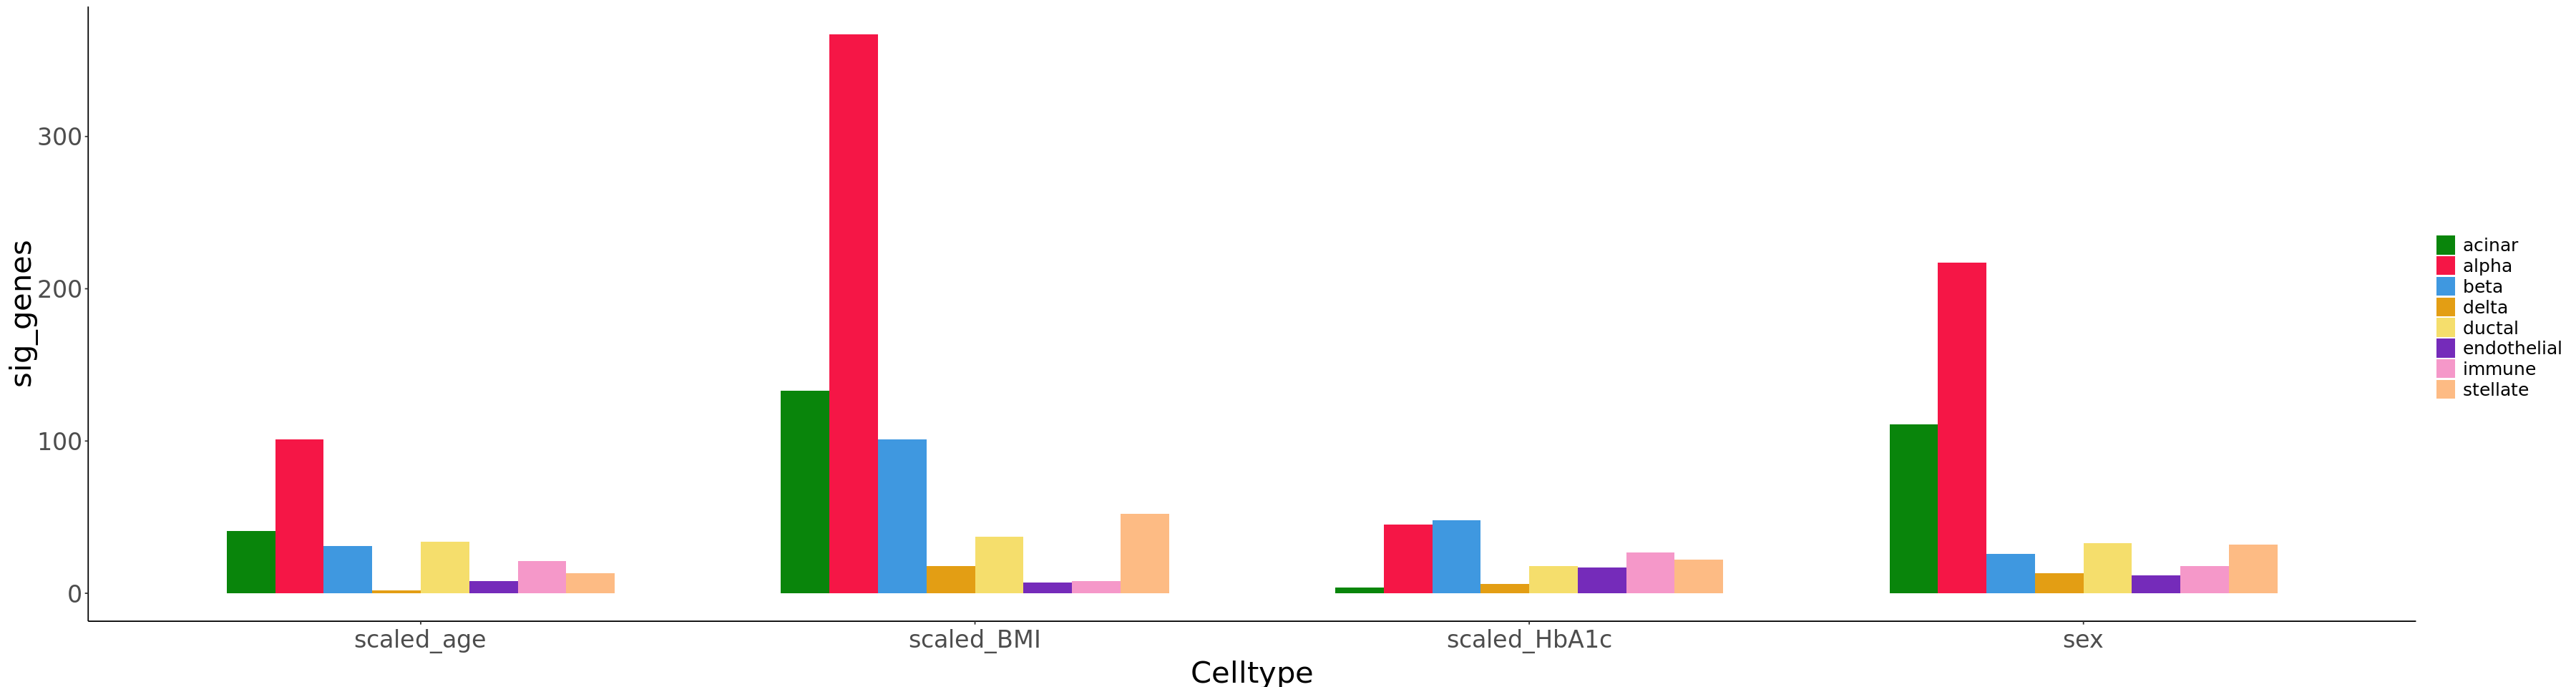

In [20]:
#I moved the outputs to the project directory so updating outdir
variables <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
summarize_DEGs(deseq_outdir, variables, joint_celltypes2, 'sig_genes', colors)

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] qvalue_2.26.0               bettermc_1.1.2             
 [3] fgsea_1.20.0                DESeq2_1.34.0              
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] MatrixGenerics_1.6.0        matrixStats_1.3.0          
